In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evallm
from automata.fa.dfa import DFA
import tqdm.auto as tqdm

In [3]:
import itertools

In [39]:
results = {}
for num_states in [3, 4, 5, 6, 7, 8]:
    results[num_states] = {}
    for num_sequence_symbols in [
        30,
        40,
        50,
        60,
        70,
        80,
        90,
        100,
        120,
        140,
        160,
        180,
        200,
    ]:
        results[num_states][num_sequence_symbols] = (
            evallm.experiments.run_transducer_experiment(
                "meta-llama/Meta-Llama-3-8B",
                num_states=num_states,
                num_alphabet_symbols=3,
                prompter=evallm.prompting.BasicInstructionTransducerPrompter(
                    num_sequence_symbols
                ),
                num_repeats_per_dfa=30,
                num_dfas=100,
            )
        )

In [40]:
relative_to_null = pd.DataFrame(
    {
        num_states: {
            num_sequence_symbols: np.mean(
                [
                    x.success_rate > x.null_success_rate
                    for x in results[num_states][num_sequence_symbols]
                ]
            )
            for num_sequence_symbols in results[num_states]
        }
        for num_states in results
    }
)

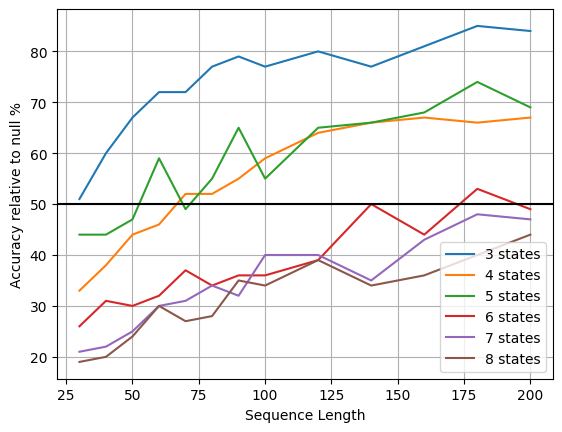

In [42]:
for k in relative_to_null:
    plt.plot(relative_to_null[k].index, relative_to_null[k] * 100, label=f"{k} states")
plt.legend()
plt.xlabel("Sequence Length")
plt.ylabel("Accuracy relative to null %")
plt.axhline(50, color="black")
plt.grid()
plt.show()